# Forest Fire Agent-Based Model in Mesa

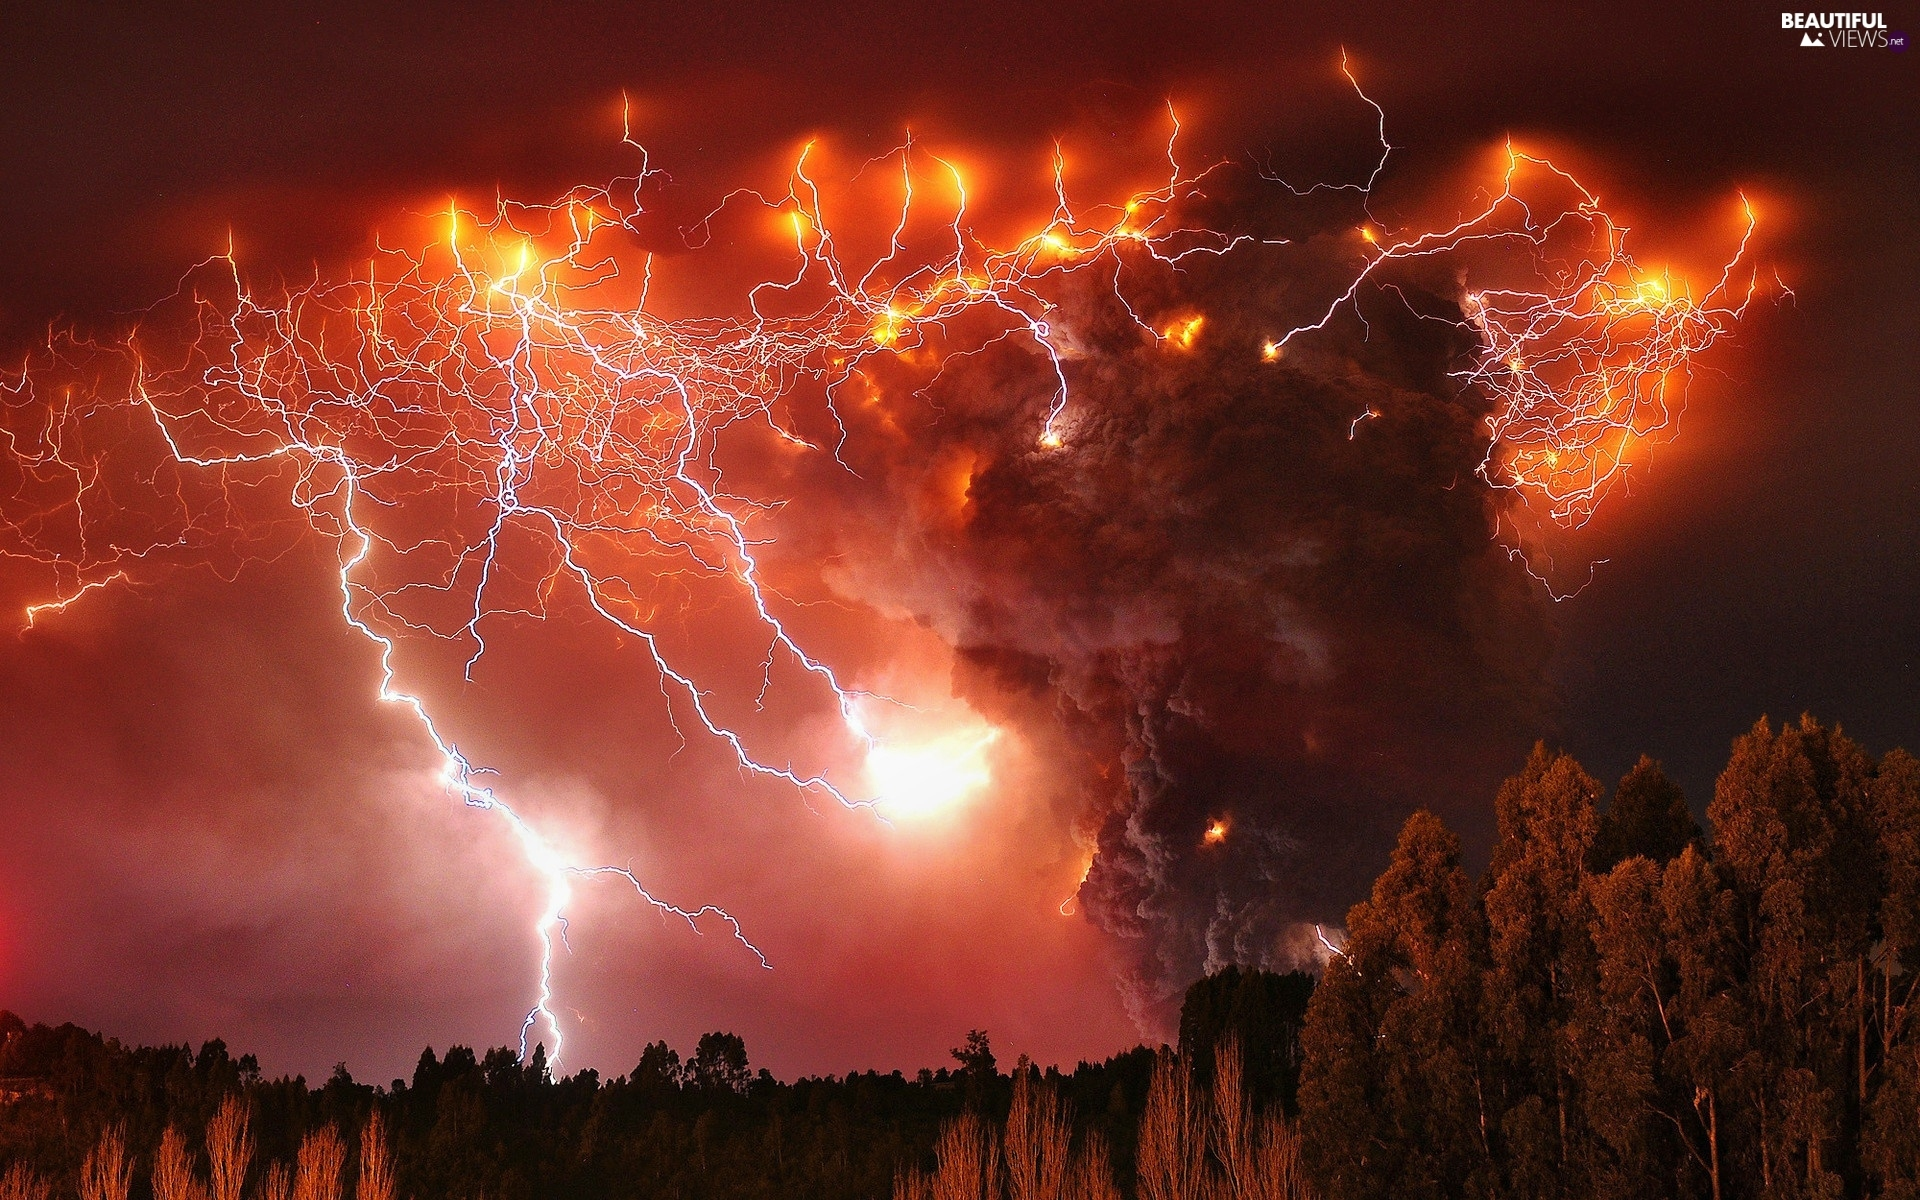

In [168]:
Image(filename='smoke-forest-lightning-fire.jpg',width = 500, height = 500)

In [150]:
from IPython.display import Image
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from numpy.random import uniform
from numpy import multiply
from scipy.ndimage.filters import gaussian_filter

 Below is the basic forest fire model. I would like to add simulated ancillary flammability data for each tree agent. Following, I would like to include a simple drought factor that, if true, would increase every trees probability of catching fire. The result should be a little closer to life considering that different trees have different resin content and other factors that increase or decrease their probability of catching fire and drought is often a presursor to forest fire. 

class TreeCell(Agent):
   
    def __init__(self, model, pos):
        
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
        
    def step(self):
       
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"
            
class ForestFire(Model):
    
    def __init__(self, height, width, density):
       
        self.height = height
        self.width = width
        self.density = density
        
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                   
                    new_tree = TreeCell(self, (x, y))
                
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
    
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

Below I altered the agent step by substituting a probability of catching fire whereas, before, a tree automatically caught fire 
if a neighbor was on fire. I set the probability of catching fire on a random normal curve from .65 to .8, finding that anything lower resulted in very little fire under the given tree density, and anything higher did not allow for a drought effect. Here, I am assuming that each agent is given a different flammability value, though I would like to check with someone to make sure that each aren't given the same number. 

In [169]:
Image(filename='soul_survivor.jpg',width = 500, height = 500)

FileNotFoundError: [Errno 2] No such file or directory: 'soul_survivor.jpg'

If we assign a drought parameter to the model, we can increase each tree flammability by a certain factor simulating the 
actual effects of dry conditions. At a factor of 1.2 trees with an initial flammability of 0.8 will have a .96 chance of 
igniting and trees at the lower end (0.65) will have a 0.78 chance. Here, I am having trouble 


In [157]:
class ForestFire(Model):
    
    def __init__(self, height, width, density, drought):
# add drought as a parameter above           
        self.height = height
        self.width = width
        self.density = density
        self.drought = drought

        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})

#       if self.drought == True:
#           TreeCell.flammability = TreeCell.flammability * 1.2

        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                   
                    new_tree = TreeCell(self, (x, y))
                
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
            
    def step(self):
    
        self.schedule.step()
        self.dc.collect(self)

        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    def drought(model, drought):
        for tree in model.schedule.agents:
            if model.drought == True:
                tree.flammability = tree.flammability * 1.2
    @staticmethod            
    def count_type(model, tree_condition):
        
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

class TreeCell(Agent):
    def __init__(self, model, pos):    
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        self.flammability = np.random.uniform(.65,.8)

    def step(self):
                         
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    if neighbor.flammability > np.random.uniform(0,1):
                        neighbor.condition = "On Fire"
                    else:
                        neighbor.condition = "Fine"
                    
            self.condition = "Burned Out"

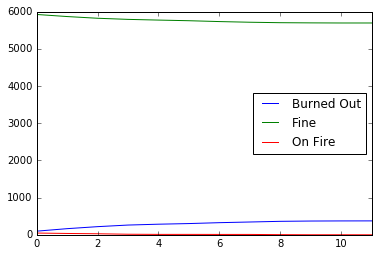

In [163]:
fire = ForestFire(100, 100, 0.6, False)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

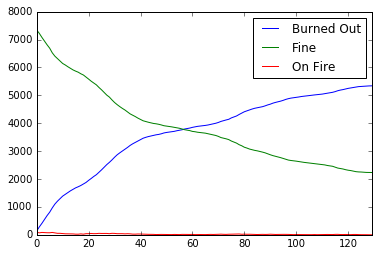

In [155]:
fire = ForestFire(100, 100, 0.75)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

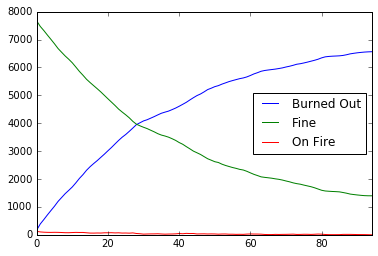

In [86]:
fire = ForestFire(100, 100, 0.8)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

In [72]:
param_set = dict(height=50,
                 width=50,
                 density=np.linspace(0,1,101)[1:])
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)
param_run.run_all()

100%|████████████████████████████████████████| 100/100 [00:09<00:00,  4.07it/s]


In [77]:
df = param_run.get_model_vars_dataframe()
df.head()

,BurnedOut,Run,density,height,width
0,0.069420,45,0.46,50,50
1,0.202532,68,0.69,50,50
2,0.368593,71,0.72,50,50
3,0.040123,12,0.13,50,50
4,0.060109,43,0.44,50,50


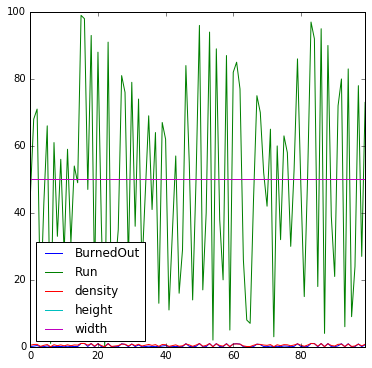

In [78]:
df.plot(figsize = [6,6])

(0, 1)

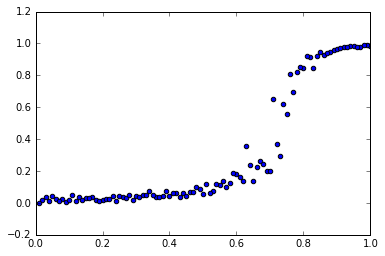

In [79]:
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

100%|████████████████████████████████████████| 500/500 [00:53<00:00,  2.72it/s]


(0, 1)

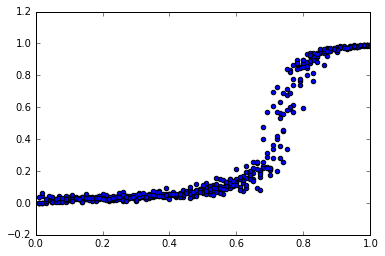

In [80]:
param_run = BatchRunner(ForestFire, param_set, iterations=5, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

In [44]:
# Practice with probability
import random
#for i in range(0,10):
#    i = random.randint(1,6)
#    print(i)
    
#for i in range(0,10):
#    i = np.random.uniform(.5,.75)
#    print(i)